# Sythesize multi instances HHM dataset

## Steps
1. Load 2-5 fg images with alphas
2. Load bg
3. Random resize: 50% - 90% bg height 
4. Random place s.t overlap < 30% of smallest mask

In [7]:
import os
import cv2
import numpy as np
from PIL import Image

### Load all image paths

In [3]:
image_root = '/mnt/localssd/HHM/train/images'
invalid_names = set()
with open('../vm2m/dataloader/invalid_him.txt', 'r') as f:
    for line in f.readlines():
        invalid_names.add(line.strip())
valid_fg = []
for image_name in os.listdir(image_root):
    if image_name in invalid_names:
        continue
    image_path = os.path.join(image_root, image_name)
    valid_fg.append(image_path)

### Load all bg paths

In [5]:
bg_root = '/mnt/localssd/bg/'
bg_paths = [os.path.join(bg_root, f) for f in os.listdir(bg_root)]

### Compose function

In [26]:
def generate_image(valid_fg, bg_paths, random):
    # 1. Random 2-5 fg images
    fg_images = random.choice(valid_fg, size=(random.randint(2, 5),), replace=False)
    alpha_images = [fg_image.replace('images', 'alphas').replace('.jpg', '.png') for fg_image in fg_images]

    # Read images
    fg_images = [Image.open(fg).convert('RGB') for fg in fg_images]
    alpha_images = [Image.open(alpha).convert('L') for alpha in alpha_images]

    # 1a. Crop fg images and alpha images following the fg region
    for i in range(len(fg_images)):
        alpha_mask = np.array(alpha_images[i])
        alpha_mask = np.where(alpha_mask > 0, 1, 0).astype(np.uint8)
        coords = cv2.findNonZero(alpha_mask)
        x, y, w, h = cv2.boundingRect(coords)
        fg_images[i] = fg_images[i].crop((x, y, x + w, y + h))
        alpha_images[i] = alpha_images[i].crop((x, y, x + w, y + h))

    # 2. Random 1 bg
    bg_image = random.choice(bg_paths)
    bg_image = Image.open(bg_image)

    target_w, target_h = bg_image.size

    # 3. Random resize fg and alpha images such that the fg height is from 50% to 90% of the target_h
    for i in range(len(fg_images)):
        scale = random.uniform(0.5, 0.9) * target_h / fg_images[i].height
        fg_images[i] = fg_images[i].resize((int(fg_images[i].width * scale), int(fg_images[i].height * scale)))
        alpha_images[i] = alpha_images[i].resize((int(alpha_images[i].width * scale), int(alpha_images[i].height * scale)))

    # 4. Random paste fg images to bg image
    final_alpha = np.zeros((len(fg_images), target_h, target_w), dtype=np.float32)
    for i in range(len(fg_images)):
        is_success = False
        new_alphas = final_alpha
        for _ in range(3):
            x = random.randint(0, target_w - fg_images[i].width)
            y = random.randint(0, target_h - fg_images[i].height)

            # Compute new alpha mask
            new_alphas = final_alpha.copy()
            new_alphas[i, y:y + fg_images[i].height, x:x + fg_images[i].width] = np.array(alpha_images[i]) / 255.0
            for j in range(i):
                new_alphas[j] *= (1 - new_alphas[i])
            new_areas = new_alphas.sum((1, 2))
            old_areas = final_alpha.sum((1, 2))
            ratio = (new_areas / (old_areas + 1e-7))
            if np.any((old_areas > 0) & (ratio < 0.7)):
                print(old_areas)
                print(new_areas)
                continue
            is_success = True
            break
        
        if not is_success:
            continue
        bg_image.paste(fg_images[i], (x, y), alpha_images[i])
        final_alpha = new_alphas
    return bg_image, final_alpha

In [35]:
# random = np.random.RandomState(2023)
final_image, final_alpha = generate_image(valid_fg, bg_paths, random)

[197383.56 250000.12      0.  ]
[ 80372.08   18892.613 594570.9  ]
[197383.56 250000.12      0.  ]
[ 51140.836  86618.52  594571.06 ]
[197383.56 250000.12      0.  ]
[168136.78    2467.002 594570.8  ]


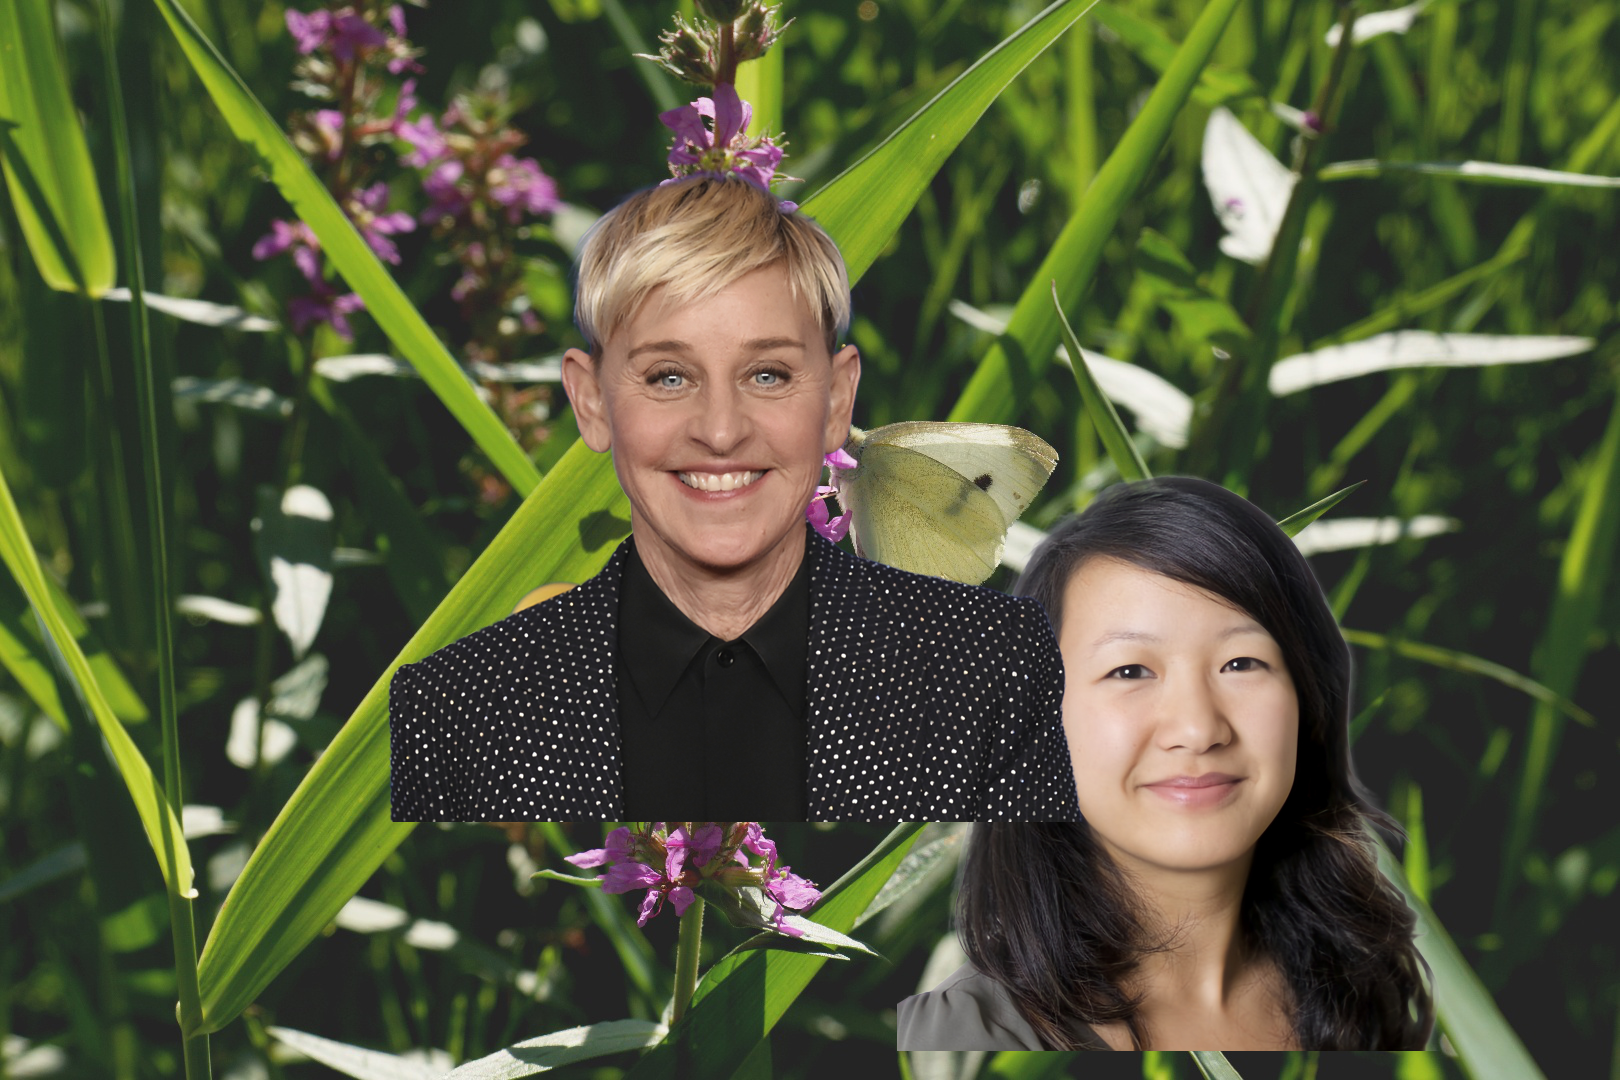

In [36]:
final_image

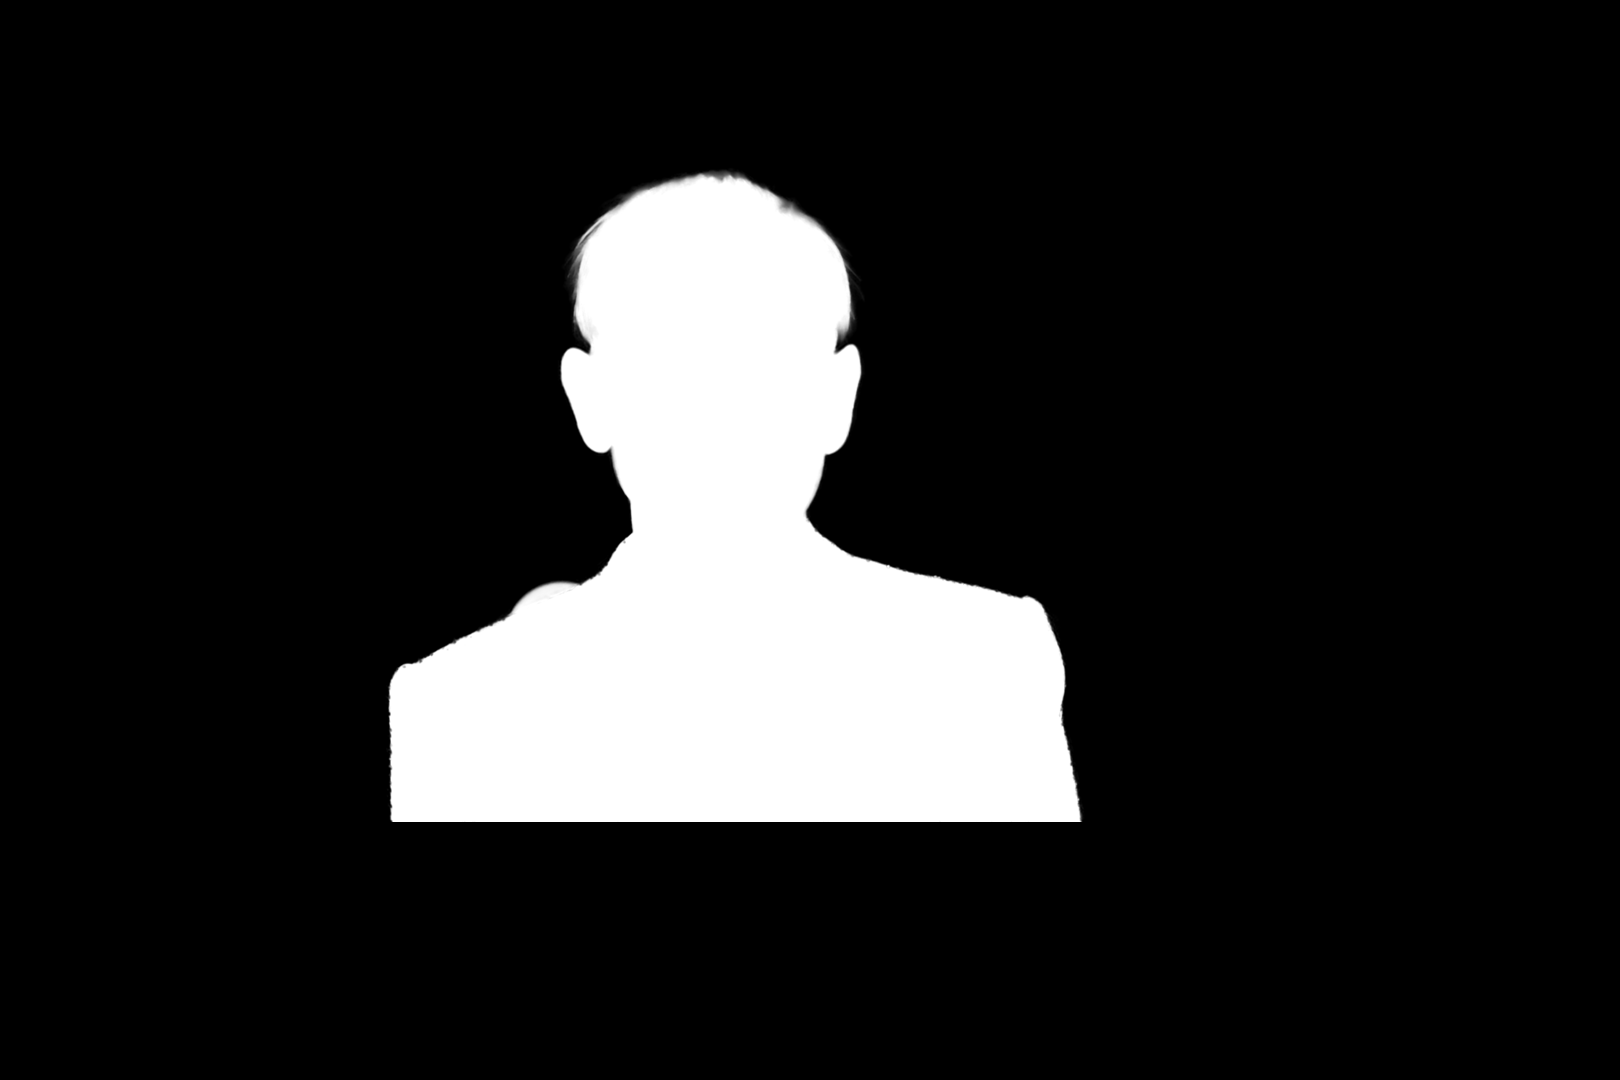

In [39]:
Image.fromarray((final_alpha[1] * 255).astype('uint8'))